In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1685129889949_0005,pyspark,idle,Link,Link,


In [2]:
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1685129889949_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached htt

In [3]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
from matplotlib.path import Path
from multiprocessing.pool import ThreadPool

from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# ssh -i ~/.aws/labsuser.pem -NL 9443:localhost:9443 hadoop@ec2-54-236-183-154.compute-1.amazonaws.com
# jupyter notebook stop 8888

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
def read_csv(filename):
    df = spark.read.csv('s3://connie318final/'+filename, 
                        header=True, inferSchema=True)
    df = df.drop(df._c0)
    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df = read_csv('demo_features.csv')
df_img_track = read_csv('imageVsTracks.csv')
df_img_area = read_csv('imageVsArea.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Feature selection

In [6]:
features = ['pagerank',
       'degree', 'clustering_coefficients',
       'links_to_high_income', 'total_population',
       '%white', "%black", 'distance_to_downtown', '%College_Educated',
       '%unemployed', 'Median gross rent_21']
df = df[['census_tract_id', 'income_21']+features]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_img = df_img_track.join(df_img_area, on="image_id")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Get average area by tract and combine with other features

In [8]:
df_area = df_img.groupBy('census_tract_id').mean()
df_area = df_area[["census_tract_id", "avg(area)"]]
df_area = df_area.withColumnRenamed("avg(area)", "area")
df_area.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-------+
|census_tract_id|   area|
+---------------+-------+
|    17031832600|34442.8|
|    17031520500|25767.4|
|    17031838000|14156.6|
|    17031440800|18375.5|
|    17031150501|25002.8|
|    17031839200|13205.9|
|    17031170500|21213.6|
|    17031830800|22645.7|
|    17031290900|13478.8|
|    17031600700|20011.6|
|    17031832000|32858.4|
|    17031420200| 8257.0|
|    17031010201|15248.4|
|    17031440102|12401.9|
|    17031832500|32821.8|
|    17031301801|14792.1|
|    17031301701|20242.6|
|    17031310500|22566.1|
|    17031301803|12323.1|
|    17031611200|17269.7|
+---------------+-------+
only showing top 20 rows

In [9]:
df = df.join(df_area, on="census_tract_id")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
print('Total Columns: %d' % len(df.dtypes))
print('Total Rows: %d' % df.count())
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 675
root
 |-- census_tract_id: long (nullable = true)
 |-- income_21: integer (nullable = true)
 |-- pagerank: double (nullable = true)
 |-- degree: integer (nullable = true)
 |-- clustering_coefficients: double (nullable = true)
 |-- links_to_high_income: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- %white: double (nullable = true)
 |-- %black: double (nullable = true)
 |-- distance_to_downtown: double (nullable = true)
 |-- %College_Educated: double (nullable = true)
 |-- %unemployed: double (nullable = true)
 |-- Median gross rent_21: integer (nullable = true)
 |-- area: double (nullable = true)

## Fill missing value with mean

In [11]:
# fillna
column_means = df.select([mean(col(column)).alias(column) 
                          for column in df.columns]).collect()[0].asDict()
df = df.fillna(column_means)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Define Random Forest Regressor and Cross Validator

In [12]:
features_col = "features"
label_col = "income_21"
features = features+['area']

# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=features, outputCol=features_col)

# Create a Random Forest regression model
rf = RandomForestRegressor(featuresCol=features_col, labelCol=label_col, numTrees=2)

# Create a pipeline for the model
pipeline = Pipeline(stages=[assembler, rf])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Split the data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
modelEvaluator = RegressionEvaluator().setLabelCol(label_col)

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder().addGrid(rf.numTrees, [2, 5, 10]).build()

# Create a cross-validator with 5 folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=modelEvaluator,
                          numFolds=5)

cvModel = crossval.fit(train_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
model = cvModel.bestModel.stages[-1]
test_df = assembler.transform(test_df)
predictions = model.transform(test_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Result-1

In [16]:
mse = modelEvaluator.evaluate(predictions, 
                             {modelEvaluator.metricName: "mse"})
r2 = modelEvaluator.evaluate(predictions, 
                             {modelEvaluator.metricName: "r2"})

# Calculate additional metrics
predicted_col = "prediction"
mean_label = test_df.select(col(label_col)).agg({label_col: "mean"}).collect()[0][0]
ss_total = test_df.select(((col(label_col) - mean_label) ** 2).
                          alias("ss_total")).agg({"ss_total": "sum"}).collect()[0][0]
ss_residual = predictions.select(((col(label_col) - col(predicted_col)) ** 2).
                          alias("ss_residual")).agg({"ss_residual": "sum"}).collect()[0][0]
explained_variance = 1 - (ss_residual / ss_total)

# Display the performance summary
print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("R-squared (R2) Score: {:.4f}".format(r2))
print("Explained Variance: {:.4f}".format(explained_variance))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mean Squared Error (MSE): 414852458.6425
R-squared (R2) Score: 0.7924
Explained Variance: 0.8342

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

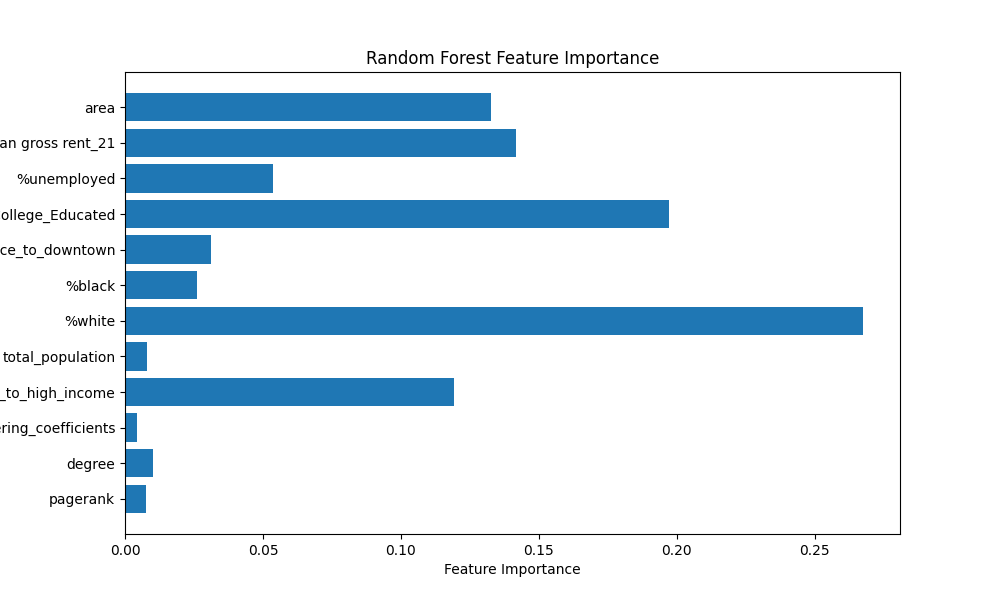

In [17]:
importances = model.featureImportances

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()
%matplot plt

## Keep only urban features

In [18]:
# now only keep urban features
features = ['pagerank', 'degree', 'clustering_coefficients', 'links_to_high_income', 'area']
assembler = VectorAssembler(inputCols=features, outputCol=features_col)

# Create a pipeline for the model
pipeline = Pipeline(stages=[assembler, rf])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Create a cross-validator with 5 folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=modelEvaluator,
                          numFolds=5)

cvModel = crossval.fit(train_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
model = cvModel.bestModel.stages[-1]
test_df = assembler.transform(test_df)
predictions = model.transform(test_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Result-2

In [22]:
mse = modelEvaluator.evaluate(predictions, 
                             {modelEvaluator.metricName: "mse"})
r2 = modelEvaluator.evaluate(predictions, 
                             {modelEvaluator.metricName: "r2"})

# Calculate additional metrics
predicted_col = "prediction"
mean_label = test_df.select(col(label_col)).agg({label_col: "mean"}).collect()[0][0]
ss_total = test_df.select(((col(label_col) - mean_label) ** 2).
                          alias("ss_total")).agg({"ss_total": "sum"}).collect()[0][0]
ss_residual = predictions.select(((col(label_col) - col(predicted_col)) ** 2).
                          alias("ss_residual")).agg({"ss_residual": "sum"}).collect()[0][0]
explained_variance = 1 - (ss_residual / ss_total)

# Display the performance summary
print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("R-squared (R2) Score: {:.4f}".format(r2))
print("Explained Variance: {:.4f}".format(explained_variance))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mean Squared Error (MSE): 679413916.0006
R-squared (R2) Score: 0.6600
Explained Variance: 0.7760

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

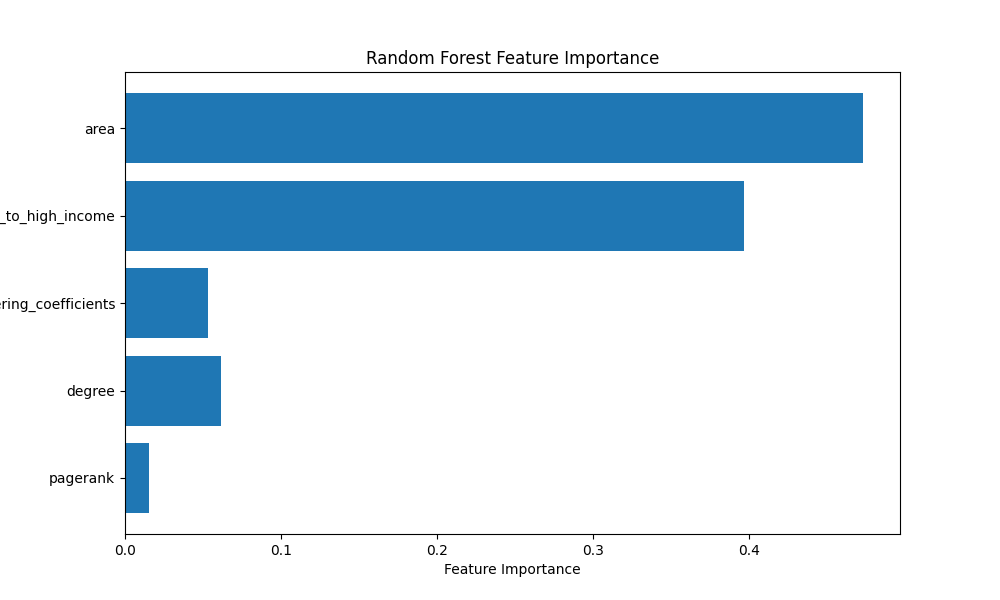

In [23]:
importances = model.featureImportances

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()
%matplot plt